# ECE 570 Assignment 6 Exercise






Your Name: Ti-Wei Chen

## Exercise 1: Creating an image denoiser using a CNN autoencoder. (30 points)
In this exercise you are trying to build a autoencoder with CNN layers that can denoise images. 

### Task 1: Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In this task, we concatenate the original dataset and noisy dataset and get a single dataloader. You should be careful with what you load at each iteration. In a more general case, there are many ways of dealing with multiple datasets. For example, you can create separate dataloaders and use ``zip`` to load samples from them. Here is a post discussing how to use ``zip`` [https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1](https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1). 

In [1]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt


class AddGaussianNoise(object):
  def __init__(self, mean=0., std=0.3):
    self.mean = mean
    self.std = std
  
  def __call__(self, tensor):
    tensor += torch.randn(tensor.size()) * self.std + self.mean
    tensor = torch.clamp(tensor, min=0, max=1)
    return tensor


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

1.0
0.0


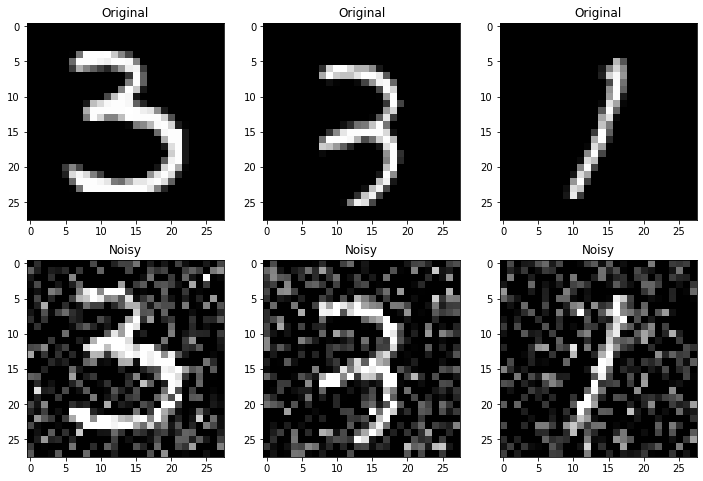

In [3]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i][0] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

# Plot the first 3 training images with corresponding noisy images 
_, (noisy, original) = next(enumerate(train_loader))
fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[0,idx].imshow(original[idx][0],cmap='gray')
  ax[0,idx].set_title(f'Original')
  ax[1,idx].imshow(noisy[idx][0],cmap='gray')
  ax[1,idx].set_title(f'Noisy')

fig.show()

### Task 2: Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is a little more complicated than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU. (This step can be simultaneously implemented in the above step)
3. Train your denoising autoencoder model with appropriate optimizer and **MSE** loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

latent_feature = 4

class our_AE(nn.Module):
  def __init__(self):
    super(our_AE, self).__init__()

    # Encoder
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=latent_feature, kernel_size=3, padding=1)
    self.pooling = nn.MaxPool2d(2,2)

    # Decoder
    self.transConv1 = nn.ConvTranspose2d(in_channels=latent_feature, out_channels=16, kernel_size=2, stride=2)
    self.transConv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2)

  def forward(self, x):
    # Encoding layers
    x = F.relu(self.conv1(x))
    x = self.pooling(x)
    x = F.relu(self.conv2(x))
    x = self.pooling(x)

    # Decoding layers
    x = F.relu(self.transConv1(x))
    x = torch.sigmoid(self.transConv2(x))
    return x

In [7]:
def train(epoch, classifier, loss_fn, optimizer, device):

  classifier.train() # we need to set the mode for our model

  for batch_idx, (noisy, images) in enumerate(train_loader): # Note that we do not need the labels
    noisy = noisy.to(device)
    images = images.to(device)
    optimizer.zero_grad()    
    output = classifier(noisy)
    loss = loss_fn(output, images)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, classifier, loss_fn, optimizer, device):

  classifier.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for noisy, images in test_loader:
      noisy = noisy.to(device)
      images = images.to(device)
      output = classifier(noisy)
      test_loss += loss_fn(output, images).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

In [8]:
# Move model to GPU
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
autoencoder = our_AE()
AE_classifier = autoencoder.to(device)

optimizer = optim.Adam(AE_classifier.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

# Train denoising autoencoder model
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 8

for epoch in range(1, max_epoch+1):
  train(epoch, AE_classifier, loss_fn, optimizer, device)
  test(epoch, AE_classifier, loss_fn, optimizer, device)


Epoch 1: [0/60000] Loss: 242.2202606201172
Epoch 1: [6400/60000] Loss: 232.99879455566406
Epoch 1: [12800/60000] Loss: 213.7491455078125
Epoch 1: [19200/60000] Loss: 176.93270874023438
Epoch 1: [25600/60000] Loss: 144.84353637695312
Epoch 1: [32000/60000] Loss: 121.69944763183594
Epoch 1: [38400/60000] Loss: 105.46029663085938
Epoch 1: [44800/60000] Loss: 97.68453216552734
Epoch 1: [51200/60000] Loss: 95.70028686523438
Epoch 1: [57600/60000] Loss: 89.88165283203125
Test result on epoch 1: Avg loss is 92.92005
Epoch 2: [0/60000] Loss: 89.21220397949219
Epoch 2: [6400/60000] Loss: 88.5084228515625
Epoch 2: [12800/60000] Loss: 87.86536407470703
Epoch 2: [19200/60000] Loss: 92.47964477539062
Epoch 2: [25600/60000] Loss: 88.42150115966797
Epoch 2: [32000/60000] Loss: 93.95100402832031
Epoch 2: [38400/60000] Loss: 88.8653564453125
Epoch 2: [44800/60000] Loss: 86.28388977050781
Epoch 2: [51200/60000] Loss: 90.54898071289062
Epoch 2: [57600/60000] Loss: 88.4996337890625
Test result on epoch 2:

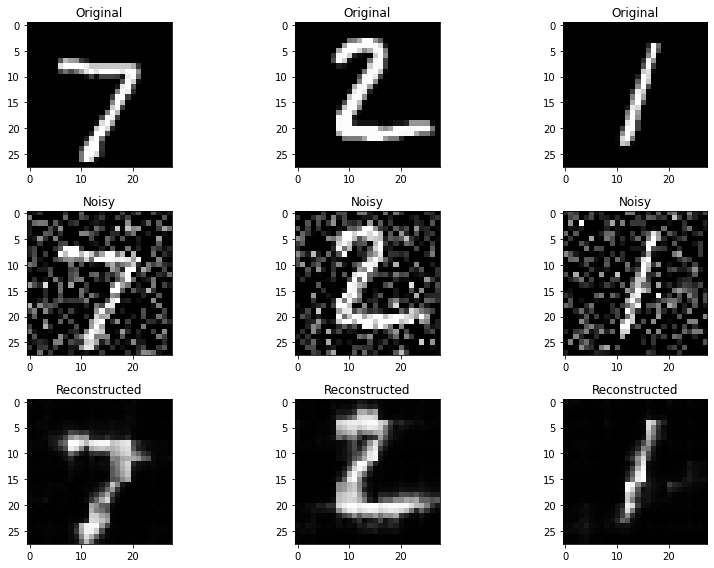

In [12]:
# Visualize the results
batch_idx, (noisy, original) = next(enumerate(test_loader))
noisy = noisy.to(device)
original = original.to(device)
output = AE_classifier(noisy).cpu().detach()
noisy = noisy.cpu()
original = original.cpu()

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,8)

for idx in range(3):
  ax[0,idx].imshow(original[idx][0], cmap='gray')
  ax[0,idx].set_title('Original')
  ax[1,idx].imshow(noisy[idx][0], cmap='gray')
  ax[1,idx].set_title('Noisy')
  ax[2,idx].imshow(output[idx][0], cmap='gray')
  ax[2,idx].set_title('Reconstructed')

plt.tight_layout()
fig.show()

## Exercise 2: Build a variational autoencoder(VAE) that can generate MNIST images (70 points)

### Task 0: Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Specify the device.

In [13]:
train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

We are using device name "cuda"


### Task 1: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
In this exercise, you will build the VAE (variational autoencoder) model satisfying following conditions which simplifies the computation of loss function:
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance along each dimension.
3. The output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.

While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
With such assumpition, the reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See [torch.nn.functional.binary_cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy).
You should use the sum reduction of the loss to sum the loss over all the pixels. 

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If we assume $p_g(z)$ is a standard normal distribution and $q_f(z|x)$ is a Gaussian with unknown mean and variance, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$. 


Your task here is to write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var (i.e., the $\log(\sigma_j^2)$ term), and returns the the reconstruction loss and the KL loss terms **separately** (i.e., the function should return two loss arrays). To visualize these losses separately in a later task, you will need the reconstruction loss and KL loss separated.


In [30]:
def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  recon_loss_fn = nn.BCELoss(reduction='sum')
  recon_loss = recon_loss_fn(output, images)
  KL = -(0.5) * torch.sum(1 + log_var - torch.pow(mu, 2) - torch.exp(log_var))

  return recon_loss, KL


### Task 2: VAE model
Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.
* Inside the `reparameterize` function you job is to output a latent vector. You should first calculate the standard deviation `std` from the log variance variable `log_var` (i.e., compute $\sigma$ from $\log (\sigma^2)$, then generate the vector in Gaussian distribution with `mu` and `std`.  **Importantly**, this should use the reparametrization trick so that we can backpropagate through this random step.

* Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature and for each instance in the batch.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [31]:
import torch.nn as nn
import torch.nn.functional as F


class our_VAE(nn.Module):
  def __init__(self, latent_feature = 16): # you can use any number of latent features you want in the training
    super(our_VAE, self).__init__()

    self.latent_feature = latent_feature

    # Encoder
    self.fc1 = nn.Linear(in_features=28*28, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=latent_feature*2)

    # Decoder
    self.fc3 = nn.Linear(in_features=latent_feature, out_features=512)
    self.fc4 = nn.Linear(in_features=512, out_features=28*28)

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using 
    the reparameterization trick.
    """

    std = torch.exp(0.5 * log_var)
    eps = torch.rand_like(std)
    sample = mu + eps * std

    return sample

  def encoder(self, x):
    """
    :param x: input distribution

    You should first compute the parameters mu and log_var for Gaussian distribution q(z|x), and 
    then get samples from q(z|x) using the reparameterize function you just created.
    The final output should include mu, log_var and z~q(z|x)
    """

    # Encoding Layer
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = self.fc2(x).view(-1, 2, self.latent_feature)
    mu = x[:,0,:]
    log_var = x[:,1,:]
    z = self.reparameterize(mu, log_var)

    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    You should compute the output x given latent samples z
    """

    # Decoding Layer
    z = F.relu(self.fc3(z))
    z = torch.sigmoid(self.fc4(z))
    z = z.view(-1, 1, 28, 28)

    return z


  
  def forward(self, x):
    """
    :param x: input variables

    You should compute the output images using the encoder and decoder you just defined.
    Remember to return the mu and log_var for the computation of loss.
    """

    mu, log_var, z = self.encoder(x)
    x = self.decoder(z)
    
    return x, mu, log_var


### Task 3: Train and visualize output
1. Train your model with an appropriate optimizer and the above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should **show three pairs of images** where each pair consists of an original test image and its VAE reconstructed version.

3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and **create a plot with three curves** using [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. **Make sure you clearly specify the legend, x-label and y-label.**

**Note:** It is always a good idea to keep track of the loss in the process of training to help you understand what is happening during training.

In [21]:
def train(epoch, classifier, optimizer, device):

  classifier.train() # we need to set the mode for our model

  for batch_idx, (images, _) in enumerate(train_loader): # Note that we do not need the labels
    images = images.to(device)
    optimizer.zero_grad()    
    output, mu, log_var = classifier(images)
    recon_loss, KL = vae_loss(output, mu, log_var, images)
    loss = recon_loss + KL
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      recon_losses.append(recon_loss.item()/batch_size_train)
      KL_losses.append(KL.item()/batch_size_train)
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, classifier, optimizer, device):

  classifier.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images.to(device)
      output, mu, log_var = classifier(images)
      recon_loss, KL = vae_loss(output, mu, log_var, images)
      loss = recon_loss + KL
      test_loss += loss.item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')


In [32]:
variational_autoencoder = our_VAE(latent_feature=2)
VAE_classifier = variational_autoencoder.to(device)
optimizer = optim.Adam(VAE_classifier.parameters(), lr=1e-4)

# Train VAE
train_losses = []
train_counter = []
test_losses = []
test_counter = []
recon_losses = []
KL_losses = []
max_epoch = 3

for epoch in range(1, max_epoch+1):
  train(epoch, VAE_classifier, optimizer, device)
  test(epoch, VAE_classifier, optimizer, device)

Epoch 1: [0/60000] Loss: 547.4825439453125
Epoch 1: [6400/60000] Loss: 232.83811950683594
Epoch 1: [12800/60000] Loss: 199.0074920654297
Epoch 1: [19200/60000] Loss: 193.85157775878906
Epoch 1: [25600/60000] Loss: 192.52041625976562
Epoch 1: [32000/60000] Loss: 192.82565307617188
Epoch 1: [38400/60000] Loss: 192.73721313476562
Epoch 1: [44800/60000] Loss: 196.98902893066406
Epoch 1: [51200/60000] Loss: 186.8354949951172
Epoch 1: [57600/60000] Loss: 185.55775451660156
Test result on epoch 1: Avg loss is 181.85823125
Epoch 2: [0/60000] Loss: 175.35748291015625
Epoch 2: [6400/60000] Loss: 179.27220153808594
Epoch 2: [12800/60000] Loss: 182.2359161376953
Epoch 2: [19200/60000] Loss: 175.4650115966797
Epoch 2: [25600/60000] Loss: 193.1713104248047
Epoch 2: [32000/60000] Loss: 183.0021209716797
Epoch 2: [38400/60000] Loss: 178.88999938964844
Epoch 2: [44800/60000] Loss: 186.737548828125
Epoch 2: [51200/60000] Loss: 173.45382690429688
Epoch 2: [57600/60000] Loss: 177.0166778564453
Test result

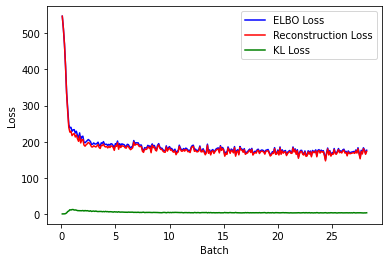

In [33]:
import numpy as np

def plot_loss(batch, ELBO_losses, recon_losses, KL_losses):
  plt.plot(batch, ELBO_losses, color='b', label='ELBO Loss')
  plt.plot(batch, recon_losses, color='r', label='Reconstruction Loss')
  plt.plot(batch, KL_losses, color='g', label='KL Loss')
  plt.xlabel("Batch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

batch = np.linspace(1, len(recon_losses), num=len(recon_losses), retstep=10)
batch = [i/10 for i in list(batch[0])]
plot_loss(batch, train_losses, recon_losses, KL_losses)

### Task 4.1: Latent space of VAE

The latent space will change over time during training as the networks learn which features of the input are most important.  In the beginning, the reconstruction error will be poor and the latent space will be mixed up (i.e., it has not identified good features for dimensionality reduction and then reconstruction).  However, as it continues to train, the space will begin to show some structure (similar to in PCA) as it finds features that enable good reconstruction even after adding a little noise. Therefore, to get some intuition about this process, in this task, you will visualize how latent space changes in the process of training with the given function ``plot_latent``.

1. For better visualization, create a VAE with ``latent_features=2``.
2. Similar to task 3, train the VAE for a few epochs. But you will need to plot the latent distribution using the provided ``plot_latent`` function below at initialization (so you can see what the latent space looks like at initialization) AND after **each** epoch. You should use the **test** data for plotting this visualization task.


In [34]:
def plot_latent(vae, data_loader, num_batches=2):
  with torch.no_grad():
    for ibx, (images,label) in enumerate(data_loader):
      _,_,z = vae.encoder(images)
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

Epoch 1: [0/60000] Loss: 549.1766967773438
Epoch 1: [6400/60000] Loss: 226.0478057861328
Epoch 1: [12800/60000] Loss: 210.79307556152344
Epoch 1: [19200/60000] Loss: 203.54356384277344
Epoch 1: [25600/60000] Loss: 190.03025817871094
Epoch 1: [32000/60000] Loss: 192.4793701171875
Epoch 1: [38400/60000] Loss: 185.22592163085938
Epoch 1: [44800/60000] Loss: 190.58447265625
Epoch 1: [51200/60000] Loss: 189.53517150878906
Epoch 1: [57600/60000] Loss: 180.01966857910156
Test result on epoch 1: Avg loss is 181.054825


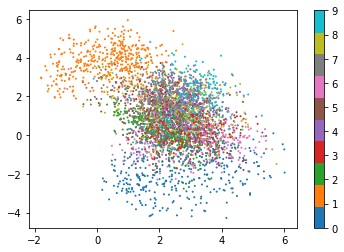

Epoch 2: [0/60000] Loss: 184.6963348388672
Epoch 2: [6400/60000] Loss: 176.19662475585938
Epoch 2: [12800/60000] Loss: 184.59719848632812
Epoch 2: [19200/60000] Loss: 174.890625
Epoch 2: [25600/60000] Loss: 170.99118041992188
Epoch 2: [32000/60000] Loss: 171.4956512451172
Epoch 2: [38400/60000] Loss: 170.3607635498047
Epoch 2: [44800/60000] Loss: 170.40931701660156
Epoch 2: [51200/60000] Loss: 168.8428955078125
Epoch 2: [57600/60000] Loss: 176.45652770996094
Test result on epoch 2: Avg loss is 172.55234375


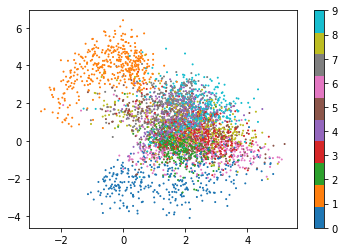

Epoch 3: [0/60000] Loss: 174.79342651367188
Epoch 3: [6400/60000] Loss: 173.33377075195312
Epoch 3: [12800/60000] Loss: 180.11703491210938
Epoch 3: [19200/60000] Loss: 181.65415954589844
Epoch 3: [25600/60000] Loss: 183.04318237304688
Epoch 3: [32000/60000] Loss: 175.3539276123047
Epoch 3: [38400/60000] Loss: 177.8368682861328
Epoch 3: [44800/60000] Loss: 174.71923828125
Epoch 3: [51200/60000] Loss: 176.54495239257812
Epoch 3: [57600/60000] Loss: 173.58665466308594
Test result on epoch 3: Avg loss is 167.8290421875


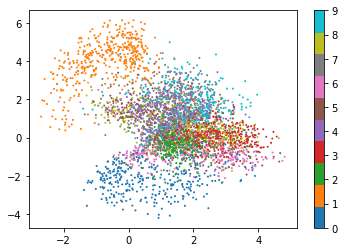

Epoch 4: [0/60000] Loss: 176.1374969482422
Epoch 4: [6400/60000] Loss: 170.58453369140625
Epoch 4: [12800/60000] Loss: 166.9989776611328
Epoch 4: [19200/60000] Loss: 171.3137664794922
Epoch 4: [25600/60000] Loss: 164.18115234375
Epoch 4: [32000/60000] Loss: 164.2022705078125
Epoch 4: [38400/60000] Loss: 167.28184509277344
Epoch 4: [44800/60000] Loss: 162.17709350585938
Epoch 4: [51200/60000] Loss: 165.1186981201172
Epoch 4: [57600/60000] Loss: 165.2570037841797
Test result on epoch 4: Avg loss is 164.95155


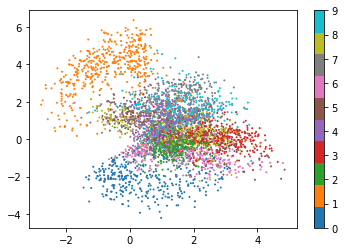

Epoch 5: [0/60000] Loss: 158.77149963378906
Epoch 5: [6400/60000] Loss: 174.49302673339844
Epoch 5: [12800/60000] Loss: 168.73536682128906
Epoch 5: [19200/60000] Loss: 168.70616149902344
Epoch 5: [25600/60000] Loss: 155.96937561035156
Epoch 5: [32000/60000] Loss: 170.16293334960938
Epoch 5: [38400/60000] Loss: 160.49928283691406
Epoch 5: [44800/60000] Loss: 164.14308166503906
Epoch 5: [51200/60000] Loss: 166.1134490966797
Epoch 5: [57600/60000] Loss: 160.90390014648438
Test result on epoch 5: Avg loss is 163.2372984375


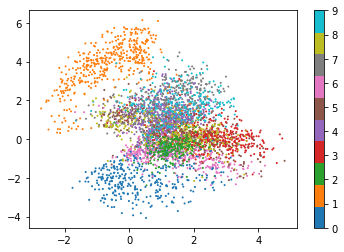

Epoch 6: [0/60000] Loss: 154.48440551757812
Epoch 6: [6400/60000] Loss: 172.19581604003906
Epoch 6: [12800/60000] Loss: 160.862548828125
Epoch 6: [19200/60000] Loss: 168.7041778564453
Epoch 6: [25600/60000] Loss: 174.21754455566406
Epoch 6: [32000/60000] Loss: 160.20584106445312
Epoch 6: [38400/60000] Loss: 158.25682067871094
Epoch 6: [44800/60000] Loss: 159.89923095703125
Epoch 6: [51200/60000] Loss: 154.59927368164062
Epoch 6: [57600/60000] Loss: 161.8917236328125
Test result on epoch 6: Avg loss is 161.9334109375


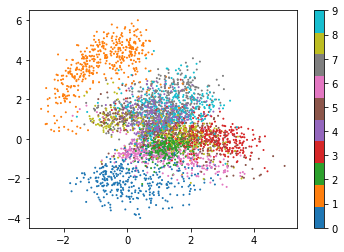

Epoch 7: [0/60000] Loss: 158.40025329589844
Epoch 7: [6400/60000] Loss: 151.19480895996094
Epoch 7: [12800/60000] Loss: 164.39312744140625
Epoch 7: [19200/60000] Loss: 163.96224975585938
Epoch 7: [25600/60000] Loss: 159.88644409179688
Epoch 7: [32000/60000] Loss: 154.56817626953125
Epoch 7: [38400/60000] Loss: 166.08261108398438
Epoch 7: [44800/60000] Loss: 154.4073486328125
Epoch 7: [51200/60000] Loss: 164.65748596191406
Epoch 7: [57600/60000] Loss: 163.71759033203125
Test result on epoch 7: Avg loss is 160.9077203125


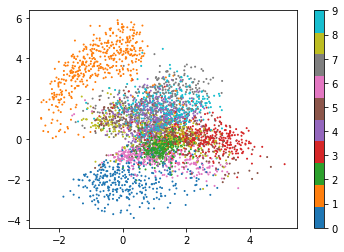

Epoch 8: [0/60000] Loss: 160.03753662109375
Epoch 8: [6400/60000] Loss: 157.644287109375
Epoch 8: [12800/60000] Loss: 151.3435516357422
Epoch 8: [19200/60000] Loss: 161.73768615722656
Epoch 8: [25600/60000] Loss: 161.9532012939453
Epoch 8: [32000/60000] Loss: 161.5896759033203
Epoch 8: [38400/60000] Loss: 164.82493591308594
Epoch 8: [44800/60000] Loss: 164.75991821289062
Epoch 8: [51200/60000] Loss: 156.44171142578125
Epoch 8: [57600/60000] Loss: 161.06419372558594
Test result on epoch 8: Avg loss is 160.031959375


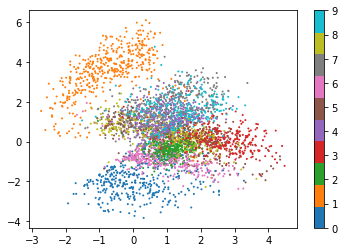

Epoch 9: [0/60000] Loss: 158.5489959716797
Epoch 9: [6400/60000] Loss: 154.6649169921875
Epoch 9: [12800/60000] Loss: 169.03274536132812
Epoch 9: [19200/60000] Loss: 159.26947021484375
Epoch 9: [25600/60000] Loss: 164.47023010253906
Epoch 9: [32000/60000] Loss: 164.3162384033203
Epoch 9: [38400/60000] Loss: 159.7331085205078
Epoch 9: [44800/60000] Loss: 163.1739959716797
Epoch 9: [51200/60000] Loss: 157.3485565185547
Epoch 9: [57600/60000] Loss: 165.272705078125
Test result on epoch 9: Avg loss is 159.28964375


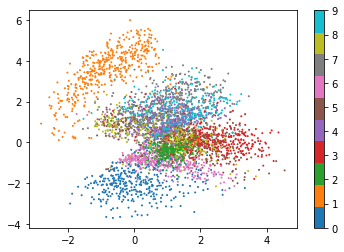

Epoch 10: [0/60000] Loss: 164.8453369140625
Epoch 10: [6400/60000] Loss: 153.19271850585938
Epoch 10: [12800/60000] Loss: 156.6396942138672
Epoch 10: [19200/60000] Loss: 148.0275421142578
Epoch 10: [25600/60000] Loss: 155.89927673339844
Epoch 10: [32000/60000] Loss: 168.81976318359375
Epoch 10: [38400/60000] Loss: 158.8907012939453
Epoch 10: [44800/60000] Loss: 153.13223266601562
Epoch 10: [51200/60000] Loss: 170.72177124023438
Epoch 10: [57600/60000] Loss: 168.5272216796875
Test result on epoch 10: Avg loss is 158.7243703125


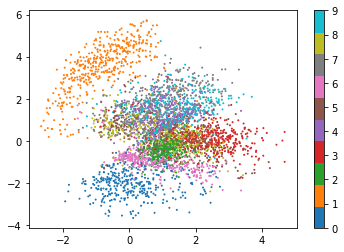

In [36]:
vae = our_VAE(latent_feature=2)
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

# Train VAE
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 10

for epoch in range(1, max_epoch+1):
  vae = vae.to(device)
  train(epoch, vae, optimizer, device)
  test(epoch, vae, optimizer, device)
  vae = vae.cpu()
  plot_latent(vae, test_loader)

### Task 4.2 Interpolation of latent space

Interpolation can be quite useful for autoencoder models. For example, by linearly interpolating (or mixing) codes in latent space and decoding the result, the autoencoder can produce a more **semantically meaningful**
combination of the corresponding datapoints than linear interpolation in the raw pixel space. 
Besides, in some cases, interpolation experiments can show that the model has learned a latent space with a particular structure. Specifically, if interpolation between points in the latent space shows a smooth semantic warping in the original image space, then the visualization may suggest that similar points are semantically clustered in the latent space.

In this task, you will do a simple experiment to see the difference between linear interpolation in the latent space and the original data space (raw pixels).
1. With a trained model and test data, sample one $z\sim q(z|x)$ corresponding to label 0 and 1 separately (two samples in total); this can be done by passing test samples (with labels 0 and 1 respectively) through the encoder. These two latent samples will be denoted $z_0$ and $z_1$ respectively.

2. Compute the linear interpolation of $x_0$ and $x_1$ in the following way: $x'=\alpha x_1 + (1-\alpha)x_0$ where $\alpha = 0, 0.1, 0.2, \dots, 0.9, 1.0$. **Plot** all $x'$ images you get in a 1x11 grid.

3. Compute the latent linear interpolation of $z_0$ and $z_1$ to get $z'$ in a similar way. Then, reconstruct the $x'$ corresponding to each $z'$ using the decoder. **Plot** all $x'$ images you get in a 1x11 grid.

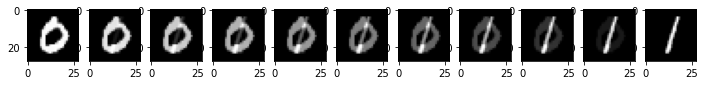

In [38]:
batch_idx, (images, labels) = next(enumerate(test_loader))
image_0 = images[labels == 0][0]
image_1 = images[labels == 1][0]
mu, log_var, z_0 = vae.encoder(image_0)
mu, log_var, z_1 = vae.encoder(image_1)

fig, ax = plt.subplots(1,11)
fig.set_size_inches(12, 8)

alpha = torch.linspace(0, 1, 11)
for i in range(0, len(alpha)):
  x_prime = torch.mul(image_0, (1 - alpha[i])) + torch.mul(image_1, alpha[i])
  ax[i].imshow(x_prime[0], cmap='gray')

fig.show()

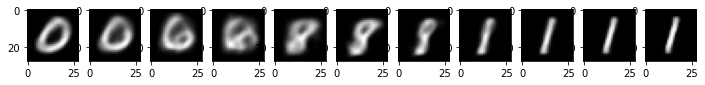

In [40]:
fig, ax = plt.subplots(1,11)
fig.set_size_inches(12, 8)

alpha = torch.linspace(0, 1, 11)
for i in range(0, len(alpha)):
  z_prime = torch.mul(z_0, (1 - alpha[i])) + torch.mul(z_1, alpha[i])
  x_prime = vae.decoder(z_prime)
  ax[i].imshow(x_prime.detach().squeeze(), cmap='gray')
